In [1]:
!pip install --upgrade tensorflow_federated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 2.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 4.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 MB 2.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━

In [4]:

!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"mewkhi","key":"51a23160bc635731f18e0b9a7bc75b53"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hereisburak/pins-face-recognition
!mkdir PinsData
!unzip -q pins-face-recognition.zip -d ./PinsData

Dataset URL: https://www.kaggle.com/datasets/hereisburak/pins-face-recognition
License(s): CC0-1.0
pins-face-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘PinsData’: File exists
replace ./PinsData/105_classes_pins_dataset/pins_Adriana Lima/Adriana Lima0_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [10]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
import cv2
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Specify the path to the dataset directory
dataset_path = "PinsData/105_classes_pins_dataset"

# Define the transform for the DataLoader used for visualization (with normalization)
transform_visualize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the ImageFolder dataset with normalization
visualize_dataset = ImageFolder(dataset_path, transform=transform_visualize)

# Define the network architecture
class AlexNet(nn.Module):
    def __init__(self, num_classes=105):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

learning_rate = 0.004

# Initialize the global model
global_model = AlexNet().to(device)

# Define the optimizer and loss function for the global model
optimizer = optim.Adam(global_model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

# Load the dataset
dataset = ImageFolder(dataset_path, transform=transform_visualize)

# Create a directory to save the perturbed images
perturbed_dir = "perturbed_images"
os.makedirs(perturbed_dir, exist_ok=True)

# Define the epsilon value for the DeepFool attack
epsilon = 0.03

# Modified DeepFool attack to increase perturbation
def deepfool_attack_batch(images, model, epsilon, reduction_factor=0.95):
    model.eval()
    perturbed_images = images.clone().detach().requires_grad_(True).to(device)

    with torch.no_grad():
        outputs = model(images)
        original_labels = torch.argmax(outputs, dim=1)

    outputs_grad = None
    while True:
        outputs = model(perturbed_images)
        predicted_labels = torch.argmax(outputs, dim=1)

        if torch.all(predicted_labels == original_labels):
            break

        if perturbed_images.grad is not None:
            perturbed_images.grad.data.zero_()

        loss = criterion(outputs, original_labels)
        loss.backward(retain_graph=True)

        if perturbed_images.grad is not None and outputs_grad is None:
            outputs_grad = perturbed_images.grad.data.clone()

        if outputs_grad is not None:
            perturbation = torch.abs(loss) / torch.norm(outputs_grad.view(images.size(0), -1), dim=1).view(-1, 1, 1, 1)
            perturbed_images = perturbed_images + perturbation * outputs_grad / torch.norm(outputs_grad.view(images.size(0), -1), dim=1).view(-1, 1, 1, 1)
            perturbed_images = torch.clamp(perturbed_images, 0, 1)
            perturbed_images = perturbed_images.clone().detach().requires_grad_(True).to(device)
        else:
            raise ValueError("No gradient computed for perturbed_images. The attack can't proceed.")

    return perturbed_images.detach()

# Apply the modified DeepFool attack to the entire dataset and save the perturbed images
batch_size = 64
total_images = len(visualize_dataset)
num_batches = (total_images + batch_size - 1) // batch_size

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, total_images)

    # Get a batch of images and labels
    images, labels = zip(*[visualize_dataset[i] for i in range(start_idx, end_idx)])
    images = torch.stack(images).to(device)
    labels = torch.tensor(labels).to(device)

    # DeepFool attack for the batch of images
    perturbed_images = deepfool_attack_batch(images, global_model, epsilon)

    for j in range(end_idx - start_idx):
        # Convert the perturbed image to a numpy array and change the channel order
        perturbed_image_np = perturbed_images[j].squeeze().detach().cpu().numpy().transpose(1, 2, 0)

        # Convert the image to the BGR color format for saving
        perturbed_image_bgr = cv2.cvtColor((perturbed_image_np * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

        # Get the class label of the image
        class_label = visualize_dataset.classes[labels[j]]

        # Create a subdirectory for the class label if it does not exist
        class_subdir = os.path.join(perturbed_dir, class_label)
        os.makedirs(class_subdir, exist_ok=True)

        # Save the perturbed image in the class subdirectory
        perturbed_image_path = os.path.join(class_subdir, f"perturbed_{start_idx + j}.jpg")
        cv2.imwrite(perturbed_image_path, perturbed_image_bgr)

        # Undo normalization on the original image
        original_image_np = images[j].squeeze().detach().cpu().numpy().transpose(1, 2, 0)
        original_image_np = (original_image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
        original_image_np = original_image_np.astype(np.uint8)

        # Convert the image to the BGR color format for visualization
        original_image_bgr = cv2.cvtColor(original_image_np, cv2.COLOR_RGB2BGR)
     

Using 8 GPUs for Data Parallelism.


/SASTRA-NEW-CLUSTER/users/srikar/MiniProject/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/SASTRA-NEW-CLUSTER/users/srikar/MiniProject/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50]
Train Loss: 4.7086 | Train Accuracy: 2.00%
Test Loss: 4.6724 | Test Accuracy: 1.74%

Epoch [2/50]
Train Loss: 4.5016 | Train Accuracy: 3.07%
Test Loss: 4.4905 | Test Accuracy: 2.28%

Epoch [3/50]
Train Loss: 4.3456 | Train Accuracy: 3.98%
Test Loss: 3.9593 | Test Accuracy: 7.33%

Epoch [4/50]
Train Loss: 4.1444 | Train Accuracy: 6.07%
Test Loss: 3.5427 | Test Accuracy: 12.32%

Epoch [5/50]
Train Loss: 3.9577 | Train Accuracy: 7.99%
Test Loss: 3.3292 | Test Accuracy: 15.65%

Epoch [6/50]
Train Loss: 3.8118 | Train Accuracy: 10.37%
Test Loss: 3.1603 | Test Accuracy: 19.59%

Epoch [7/50]
Train Loss: 3.6528 | Train Accuracy: 11.92%
Test Loss: 3.1085 | Test Accuracy: 19.76%

Epoch [8/50]
Train Loss: 3.4903 | Train Accuracy: 14.71%
Test Loss: 2.8543 | Test Accuracy: 25.95%

Epoch [9/50]
Train Loss: 3.3316 | Train Accuracy: 17.38%
Test Loss: 2.7632 | Test Accuracy: 28.77%

Epoch [10/50]
Train Loss: 3.1979 | Train Accuracy: 19.67%
Test Loss: 2.6565 | Test Accuracy: 30.23%

Epoch [

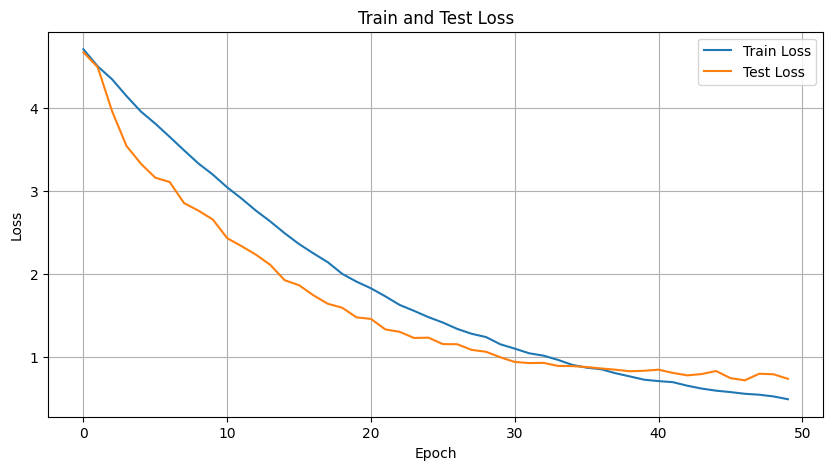

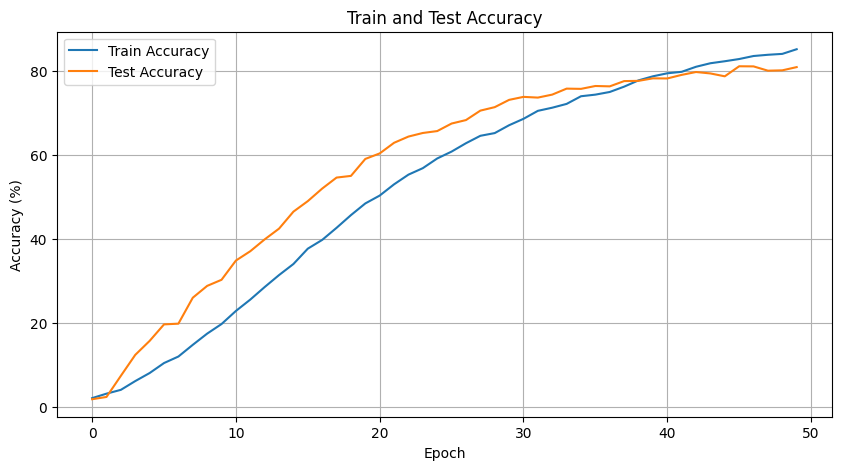

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataset import Subset
from torchvision.models import resnet18
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Check if multiple GPUs are available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transform to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Specify the path to the dataset directory
dataset_path = "perturbed_images"

# Define the network architecture (using ResNet18)
class ResNet18(nn.Module):
    def __init__(self, num_classes=105):
        super(ResNet18, self).__init__()
        self.model = resnet18(pretrained=True)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Wrap the model with DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for Data Parallelism.")
    global_model = nn.DataParallel(ResNet18()).to(device)
else:
    global_model = ResNet18().to(device)

# Define the federated learning parameters
num_clients = 4
fraction = 0.2
num_epochs = 50
learning_rate = 0.001

# Define the optimizer and learning rate scheduler for the global model
optimizer = optim.Adam(global_model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

criterion = nn.CrossEntropyLoss()

# Divide the dataset into train and test sets
full_dataset = ImageFolder(dataset_path, transform=transform)
num_samples = len(full_dataset)
num_train_samples = int(num_samples * (1 - fraction))
num_test_samples = num_samples - num_train_samples
train_dataset, test_dataset = random_split(full_dataset, [num_train_samples, num_test_samples])

# Split the train dataset into client datasets
train_indices = list(range(len(train_dataset)))
client_datasets = []
start = 0
for _ in range(num_clients):
    end = start + int(len(train_indices) / num_clients)
    indices = train_indices[start:end]
    subset = Subset(train_dataset, indices)
    client_datasets.append(subset)
    start = end

# Function to train a local model on a client's dataset
def train_local_model(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100
    return model.state_dict(), train_loss, train_accuracy

# Function to aggregate model updates using federated averaging
def aggregate_models(global_model, local_models):
    global_dict = global_model.state_dict()
    for key in global_dict.keys():
        # Convert model weights to float
        global_dict[key] = torch.stack([local_models[i][key].float() for i in range(len(local_models))], dim=0).mean(0)
    global_model.load_state_dict(global_dict)
    return global_model

# Lists to store the values for plotting
train_losses_plot = []
train_accuracies_plot = []
test_losses_plot = []
test_accuracies_plot = []

# Train the global model using federated learning
for epoch in range(num_epochs):
    local_models = []
    train_losses = []
    train_accuracies = []

    # Train local models on client datasets
    for client_dataset in client_datasets:
        train_loader = DataLoader(client_dataset, batch_size=32, shuffle=True)
        local_model = ResNet18().to(device)
        # Wrap the local model with DataParallel if multiple GPUs are available
        if torch.cuda.device_count() > 1:
                local_model = nn.DataParallel(local_model)

        local_model.load_state_dict(global_model.state_dict())
        local_optimizer = optim.Adam(local_model.parameters(), lr=learning_rate)

        # Learning rate scheduler for local models
        local_scheduler = optim.lr_scheduler.StepLR(local_optimizer, step_size=30, gamma=0.1)

        local_model_dict, train_loss, train_accuracy = train_local_model(local_model, train_loader, local_optimizer, criterion, device)
        local_models.append(local_model_dict)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        local_scheduler.step()

    # Aggregate the local models using federated averaging
    global_model = aggregate_models(global_model, local_models)

    # Evaluation on the test set
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    global_model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = global_model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_accuracy = test_correct / test_total * 100

    # Append values to the plotting lists
    train_losses_plot.append(sum(train_losses) / len(train_losses))
    train_accuracies_plot.append(sum(train_accuracies) / len(train_accuracies))
    test_losses_plot.append(test_loss)
    test_accuracies_plot.append(test_accuracy)

    # Print the epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {sum(train_losses) / len(train_losses):.4f} | Train Accuracy: {sum(train_accuracies) / len(train_accuracies):.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")
    print()

# Plotting train and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses_plot, label='Train Loss')
plt.plot(test_losses_plot, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.grid()
plt.show()

# Plotting train and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies_plot, label='Train Accuracy')
plt.plot(test_accuracies_plot, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy')
plt.legend()
plt.grid()
plt.show()